<a href="https://colab.research.google.com/github/dxjzsyt/aiops_code/blob/main/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install fbprophet

In [10]:
import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from fbprophet import Prophet

In [11]:
csv_path='/content/drive/MyDrive/data/aiops_book/anomaly_detection/ad_data.csv'
time_series_df=pd.read_csv(csv_path)
time_series_df.load_date = pd.to_datetime(time_series_df.timestamp, format='%Y-%m-%d %H:%M:%S')
time_series_df = time_series_df.sort_values(by="timestamp")
time_series_df = time_series_df.reset_index(drop=True)
time_series_df.columns = ['ds', 'y']
time_series_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



,ds,y
0,2014-04-10 00:04:00,91.958
1,2014-04-10 00:09:00,94.798
2,2014-04-10 00:14:00,92.208
3,2014-04-10 00:19:00,93.722
4,2014-04-10 00:24:00,93.042


Displaying Prophet plot


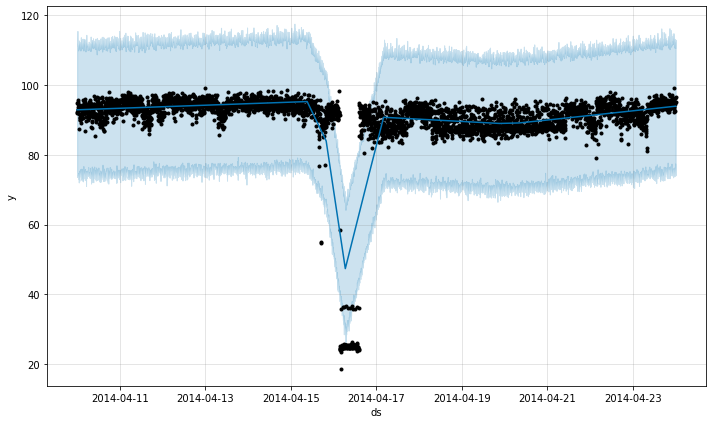

In [12]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig1 = m.plot(forecast)
    return forecast
    
pred = fit_predict_model(time_series_df)

In [13]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [14]:
pred.head()

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,2014-04-10 00:04:00,92.908776,92.908776,75.288297,112.177540,91.958,0,0.0
1,2014-04-10 00:09:00,92.910299,92.910299,74.140250,111.907824,94.798,0,0.0
2,2014-04-10 00:14:00,92.911822,92.911822,73.668807,115.522496,92.208,0,0.0
3,2014-04-10 00:19:00,92.913345,92.913345,74.191391,111.931310,93.722,0,0.0
4,2014-04-10 00:24:00,92.914868,92.914868,73.628932,111.158178,93.042,0,0.0


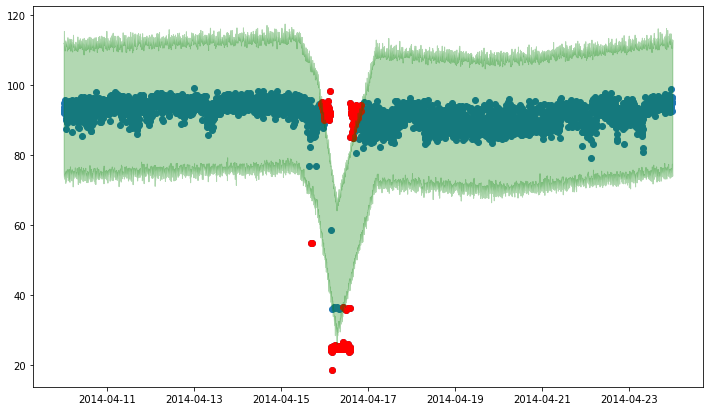

In [28]:
def plot_anomalies(forecasted):
  figsize=(12, 7)
  plt.figure(figsize=figsize)
  plt.scatter(pred['ds'],pred['fact'])
  plt.scatter(pred.loc[pred['anomaly']!=0,'ds'],pred.loc[pred['anomaly']!=0,'fact'], c = 'red')
  plt.fill_between(pred['ds'],pred['yhat_lower'],pred['yhat_upper'],color='g',alpha=0.3)
  plt.show()

plot_anomalies(pred)